<!--NOTEBOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="./figures/LogoOpenclassrooms.png">
<font size="4">
<p>
Cette étude a été réalisée dans le cadre du 6ème projet de ma formation Datascientist dispensée en MOOC par 
</p>    
<font color='blus'>Openclassrooms / écoles Centrale-Supélec</font>.
<p>
Le modèle étudié se base sur les données fournies par le site de StackOverFlow.
</p>
<p>
Ce notebook présente un système de suggestion de TAGS basé sur des méthodes statistiques.
</p>
<p>
Le traitement des données réalisé dans le notebook 'P6_DataAnalysis' sont utilisées pour alimenter les modèles.
</p>



In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import p6_util
import p6_util_plot

# <font color='blus'>5. Statistical TAGs assignement methods</font>

**Loading cleaned Posts train dataset**

In [ ]:
import p5_util
file_name='./data/ser_sof_train.dump'
ser_sof_train = p5_util.object_load(file_name)
print(ser_sof_train.shape)

**Loading test dataset**

In [ ]:
import pandas as pd
file_name="./data/test_StackOverFlow_BodyTitleTags.csv"
df_sof_test=pd.read_csv(file_name)

In [ ]:
df_sof_test['Body']=df_sof_test['Body']+df_sof_test['Title']

**Loading target : list of TAGs from SOF**

In [ ]:
import pandas as pd
file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)
print(df_sof_tags.shape)
list_sof_tag = df_sof_tags.TagName.tolist( )

## <font color='blus'>5.1 Features creation from Bag of Words</font>

* Dataset is tokenized
* Corpus is represented as a matrix
* Matrix values are tokens frequencies (TF)

**BOW Vectorization with (1-GRAM terms)**

In [ ]:
embeding_mode='bow'

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
ngram=1
vectorizer_bow = CountVectorizer(min_df=0.001, max_df=.1, ngram_range=(ngram, ngram))
csr_matrix_bow = vectorizer_bow.fit_transform(ser_sof_train)

print(csr_matrix_bow.shape)

The 24604 posts are expanded over 2463 features.

In [ ]:
import p5_util
file_name='./data/csr_matrix_bow.dump'
p5_util.object_dump(csr_matrix_bow, file_name)

file_name='./data/vectorizer_bow.dump'
p5_util.object_dump(vectorizer_bow, file_name)


### <font color='blus'>5.1.1 Statistical method evaluation based on BOW</font>

For each raw from CSR matrix, the N greater values are extracted.

Matching Key words from columns are chosen from vacabulary.

Those keywords are assigned as TAGS.


In [ ]:
nb_test = int(len(df_sof_test)/500)

modulo=int(nb_test/10)
nb_test, modulo

In [ ]:
import p6_util
dict_match_result = p6_util.p6_score_mean_string_simlarity(nb_test, df_sof_test, list_sof_tag\
    , vectorizer_bow, csr_matrix_bow,p_tag_ratio=None, embeding_mode='bow' )

In [ ]:
import p5_util
file_name='./data/dict_match_result_bow_stat.dump'
p5_util.object_dump(dict_match_result, file_name)

In [ ]:
import p5_util
file_name='./data/dict_match_result_bow_stat.dump'
dict_match_result = p5_util.object_load(file_name)

In [ ]:
import p6_util
arr_similarity_result, arr_matching_result = p6_util.p6_stat_compute_result(dict_match_result)

In [ ]:
import seaborn as sns, numpy as np
sns.set()
#x = np.random.randn(100)
ax = sns.distplot(arr_similarity_result)

In [ ]:
ax = sns.distplot(arr_matching_result, bins=30)

In [ ]:
import numpy as np

arr_index = np.where(arr_matching_result>=0.4)[0]
[print(dict_match_result[index]) for index in list(arr_index)]

## <font color='blus'>5.2 TF-IDF  with ngram=(1,1)</font>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# When building vacabulary, terms with frequency document < p_min_df are ignored.
p_min_df = 0.001

# When building vacabulary, terms with frequency document> p_max_df are ignored.
p_max_df = 1.

ngram1=1
ngram2=1
vectorizer_tfidf_ngram1=TfidfVectorizer(norm="l2", use_idf=True, min_df=p_min_df, max_df=p_max_df, ngram_range=(ngram1, ngram2))

csr_matrix_tfidf_ngram1 = vectorizer_tfidf_ngram1.fit_transform(ser_sof_train)

print(csr_matrix_tfidf_ngram1.shape)

In [ ]:
print("MIN DF= "+str(p_min_df)+"  MAX DF = "+str(p_max_df))

In [ ]:
nb_test = int(len(df_sof_test)/500)

modulo=int(nb_test/10)
print("Nb tests= {} Modulo={}".format(nb_test, modulo))

In [ ]:
import p6_util
dict_match_result = p6_util.p6_score_mean_string_simlarity(nb_test, df_sof_test, list_sof_tag\
    , vectorizer_tfidf_ngram1, csr_matrix_tfidf_ngram1,p_tag_ratio=None, embeding_mode='tfidf' )

In [ ]:
import p5_util
file_name='./data/dict_match_result_tfidf_ngram1_stat.dump'
p5_util.object_dump(dict_match_result, file_name)

In [ ]:
import p5_util
file_name='./data/dict_match_result_tfidf_ngram1_stat.dump'
dict_match_result = p5_util.object_load(file_name)

In [ ]:
import p6_util
arr_similarity_result, arr_matching_result = p6_util.p6_stat_compute_result(dict_match_result)

In [ ]:
import seaborn as sns, numpy as np
sns.set()
np.random.seed(0)
#x = np.random.randn(100)
ax = sns.distplot(arr_similarity_result)

In [ ]:
ax = sns.distplot(arr_matching_result, bins=30)

* Terms having a frequency occurence greater then ``p_max_df`` threshold are ignored
* Terms having a frequency occurence less then ``p_min_df`` threshold are ignored

## <font color='blus'>5.3 TF-IDF  with ngram=(2,2)</font>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

ngram1=2
ngram2=2
vectorizer_tfidf_ngram2=TfidfVectorizer(norm="l2", use_idf=True, min_df=p_min_df, max_df=p_max_df, ngram_range=(ngram1, ngram2))

csr_matrix_tfidf_ngram2 = vectorizer_tfidf_ngram2.fit_transform(ser_sof_train)

print(csr_matrix_tfidf_ngram2.shape)

In [ ]:
nb_test = int(len(df_sof_test)/500)

modulo=int(nb_test/10)
print("Nb tests= {} Module={}".format(nb_test, modulo))

In [ ]:
import p6_util
dict_match_result = p6_util.p6_score_mean_string_simlarity(nb_test, df_sof_test, list_sof_tag\
    , vectorizer_tfidf_ngram2, csr_matrix_tfidf_ngram2,p_tag_ratio=None, embeding_mode='tfidf' )

In [ ]:
import p5_util
file_name='./data/dict_match_result_tfidf_ngram2_stat.dump'
p5_util.object_dump(dict_match_result, file_name)

In [ ]:
import p5_util
file_name='./data/dict_match_result_tfidf_ngram2_stat.dump'
dict_match_result = p5_util.object_load(file_name)

In [ ]:
import p6_util
arr_similarity_result, arr_matching_result = p6_util.p6_stat_compute_result(dict_match_result)

In [ ]:
import seaborn as sns, numpy as np
sns.set()
np.random.seed(0)
#x = np.random.randn(100)
ax = sns.distplot(arr_similarity_result, bins=30)

In [ ]:
ax = sns.distplot(arr_matching_result, bins=30)

## <font color='blus'>5.4. TF-IDF  with ngram=(1,2)</font>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

ngram1=1
ngram2=2
vectorizer_tfidf_ngram1_2=TfidfVectorizer(norm="l2", use_idf=True, min_df=p_min_df, max_df=p_max_df, ngram_range=(ngram1, ngram2))

csr_matrix_tfidf_ngram1_2 = vectorizer_tfidf_ngram1_2.fit_transform(ser_sof_train)

print(csr_matrix_tfidf_ngram1_2.shape)

In [ ]:
nb_test = int(len(df_sof_test)/500)

modulo=int(nb_test/10)
print("Nb tests= {} Module={}".format(nb_test, modulo))

In [ ]:
import p6_util
dict_match_result = p6_util.p6_score_mean_string_simlarity(nb_test, df_sof_test, list_sof_tag\
    , vectorizer_tfidf_ngram1_2, csr_matrix_tfidf_ngram1_2,p_tag_ratio=None, embeding_mode='tfidf' )

In [ ]:
import p5_util
file_name='./data/dict_match_result_tfidf_ngram1_2_stat.dump'
p5_util.object_dump(dict_match_result, file_name)

In [ ]:
import p5_util
file_name='./data/dict_match_result_tfidf_ngram1_2_stat.dump'
dict_match_result = p5_util.object_load(file_name)

In [ ]:
import p6_util
arr_similarity_result, arr_matching_result = p6_util.p6_stat_compute_result(dict_match_result)

In [ ]:
import seaborn as sns, numpy as np
sns.set()
#x = np.random.randn(100)
ax = sns.distplot(arr_similarity_result, bins=30)

In [ ]:
ax = sns.distplot(arr_matching_result, bins=30)

## <font color='blus'> 5.5. Optimized TFIDF Vectorization</font>

**Loading target : list of TAGs from SOF**

In [1]:
import pandas as pd
file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)
print(df_sof_tags.shape)
list_sof_tag = df_sof_tags.TagName.tolist( )

(50000, 2)


**Loading test dataset**

In [2]:
import pandas as pd
file_name="./data/test_StackOverFlow_BodyTitleTags.csv"
df_sof_test=pd.read_csv(file_name)

In [13]:
df_sof_test['Body']=df_sof_test['Body']+df_sof_test['Title']

**Loading cleaned train dataset of Posts**

In [3]:
import p5_util
file_name='./data/ser_sof_train.dump'
ser_sof_train = p5_util.object_load(file_name)
print(ser_sof_train.shape)

p5_util.object_load : fileName= ./data/ser_sof_train.dump
(24604,)


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
# When building vacabulary, terms with frequency document < p_min_df are ignored.
p_min_df = 0.0006

# When building vocabulary, terms with frequency document> p_max_df are ignored.
p_max_df = 1.

ngram1=1
ngram2=1


from sklearn.feature_extraction.text import TfidfVectorizer

ngram1=1
ngram2=2
vectorizer_tfidf_ngram1_b=TfidfVectorizer(norm="l2", use_idf=True, min_df=p_min_df, max_df=p_max_df, ngram_range=(ngram1, ngram2))

csr_matrix_tfidf_ngram1_b = vectorizer_tfidf_ngram1_b.fit_transform(ser_sof_train)

print(csr_matrix_tfidf_ngram1_b.shape)

(24604, 6304)


In [5]:
print("MIN DF= "+str(p_min_df)+"  MAX DF = "+str(p_max_df))

MIN DF= 0.0006  MAX DF = 1.0


In [6]:
import p5_util
file_name='./data/csr_matrix_tfidf_ngram1_b.dump'
p5_util.object_dump(csr_matrix_tfidf_ngram1_b,file_name)
print(csr_matrix_tfidf_ngram1_b.shape)
 
file_name='./data/vectorizer_tfidf_ngram1_b.dump'
p5_util.object_dump(vectorizer_tfidf_ngram1_b,file_name)



(24604, 6304)


In [7]:
nb_test = int(len(df_sof_test)/100)

modulo=int(nb_test/10)
print("Nb tests= {} Module={}".format(nb_test, modulo))

Nb tests= 163 Module=16


In [14]:
import p6_util
dict_match_result = p6_util.p6_score_mean_string_simlarity(nb_test, df_sof_test, list_sof_tag\
    , vectorizer_tfidf_ngram1_b, csr_matrix_tfidf_ngram1_b,p_tag_ratio=None, embeding_mode='tfidf' )


Test mode tfidf covering 163 documents

Processed documents : 16/163
Processed documents : 32/163
Processed documents : 48/163
Processed documents : 64/163
Processed documents : 80/163
Processed documents : 96/163
Processed documents : 112/163
Processed documents : 128/163
Processed documents : 144/163
Processed documents : 160/163


In [15]:
import p5_util
file_name='./data/dict_match_result_tfidf_ngram1plus_stat.dump'
p5_util.object_dump(dict_match_result, file_name)

In [ ]:
import p5_util
file_name='./data/dict_match_result_tfidf_ngram1plus_stat.dump'
dict_match_result = p5_util.object_load(file_name)

In [16]:
import p6_util
arr_similarity_result, arr_matching_result = p6_util.p6_stat_compute_result(dict_match_result)


*** Mean similarity indice >100: 98.16 %

*** Mean similarity indice = 0: 0.00 %

*** Matching results : 28.83 %


/home/bangui/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


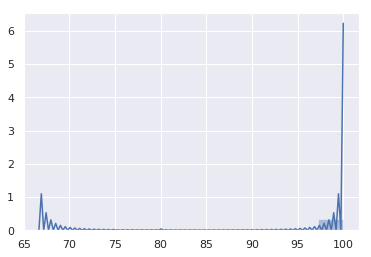

In [17]:
import seaborn as sns, numpy as np
sns.set()
np.random.seed(0)
#x = np.random.randn(100)
ax = sns.distplot(arr_similarity_result)

/home/bangui/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


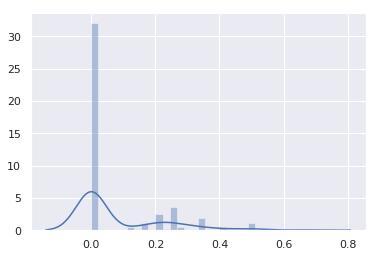

In [18]:
ax = sns.distplot(arr_matching_result, bins=30)